# Sentiment-Driven Momentum Trading Strategy

## Introduction

This strategy leverages sentiment analysis indicators alongside traditional momentum indicators to create a robust trading strategy. The sentiment indicators include BULL, BEAR, BBr, and PNlog, while the momentum indicator used is the Rate of Change (ROC).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Performance function
def performance(x, ntrades=1, cost=0):
    """
    Calculates the performance of a stock or portfolio given the returns data.
    
    Parameters:
    x (pd.Series): an array containing the daily returns of the stock or portfolio.
    ntrades (int, optional): the number of trades. Default is 1.
    cost (float, optional): the transaction cost for each trade. Default is 0.
    
    Returns:
    Series: A pandas Series object containing the performance statistics of the stock or portfolio. 
    The Series object has the following indices:
        - Cumulative Return
        - Annual Return
        - Annualized Sharpe Ratio
        - Win %
        - Annualized Volatility
        - Maximum Drawdown
        - Max Length Drawdown
        - n.trades
    """
    cumRetx = np.cumsum(x, axis=0) - ntrades * cost
    annRetx = (np.power(cumRetx[-1] + 1, 252 / len(x)) - 1)
    sharpex = annRetx / np.std(x, ddof=1) * np.sqrt(252)
    winpctx = np.count_nonzero(x > 0) / np.count_nonzero(x)
    annSDx = np.std(x, ddof=1) * np.sqrt(252)

    DDs = np.minimum.accumulate(cumRetx) - cumRetx
    maxDDx = DDs.min()
    maxLx = (cumRetx == DDs).argmax()

    Perf = np.array([cumRetx[-1], annRetx, sharpex, winpctx, annSDx, maxDDx, maxLx, ntrades])
    names = np.array(["Cumulative Return", "Annual Return", "Annualized Sharpe Ratio",
    "Win %", "Annualized Volatility", "Maximum Drawdown", "Max Length Drawdown", "n.trades"])
    return pd.Series(Perf, index=names, name=x.name)

In [3]:
# Load and set up SP500 data
# frequency of sampling
tau = 1 #data is daily. Try tau=20 (month), tau=60 (quarterly)
amzn = pd.read_csv('dataSent/AMZN.csv', sep = ",")
amzn = amzn.iloc[:, 1:]
# x = x.drop(amzn.columns[[2,3]], axis=1) ##remove ticker and ISIN (non-numerics)
# x = x.drop(amzn.columns[[0, 8]], axis=1) #for assets CVI, EURUSD
amzn.head()

,Date,Open,High,Low,Close,Adj Close,Volume,RVT,positivePartscr,negativePartscr,fearPartscr,findownPartscr,finupPartscr,finhypePartscr,certaintyPartscr,uncertaintyPartscr
0,2018-01-02,1172.000000,1190.000000,1170.510010,1189.010010,1189.010010,2694500,0.0031,0.0177,0.0105,0.0015,0.0040,0.0178,0.0242,0.0100,0.0106
1,2018-01-03,1188.300049,1205.489990,1188.300049,1204.199951,1204.199951,3108800,0.0009,0.0190,0.0105,0.0018,0.0047,0.0216,0.0178,0.0091,0.0083
2,2018-01-04,1205.000000,1215.869995,1204.660034,1209.589966,1209.589966,3022100,0.0010,0.0136,0.0226,0.0002,0.0075,0.0228,0.0121,0.0083,0.0072
3,2018-01-05,1217.510010,1229.140015,1210.000000,1229.140015,1229.140015,3544700,0.0015,0.0133,0.0260,0.0010,0.0065,0.0102,0.0129,0.0071,0.0069
4,2018-01-08,1236.000000,1253.079956,1232.030029,1246.869995,1246.869995,4279500,0.0018,0.0154,0.0174,0.0015,0.0074,0.0168,0.0166,0.0089,0.0086


In [4]:
# Load and set up MICROSFOFT data
# frequency of sampling
tau = 1 #data is daily. Try tau=20 (month), tau=60 (quarterly)
msft = pd.read_csv('dataSent/msft.csv', sep = ",")
msft = msft.iloc[:, 1:]
# x = x.drop(amzn.columns[[2,3]], axis=1) ##remove ticker and ISIN (non-numerics)
# x = x.drop(amzn.columns[[0, 8]], axis=1) #for assets CVI, EURUSD
msft.head()

,Date,Open,High,Low,Close,Adj Close,Volume,RVT,positivePartscr,negativePartscr,fearPartscr,findownPartscr,finupPartscr,finhypePartscr,certaintyPartscr,uncertaintyPartscr
0,2018-01-02,86.129997,86.309998,85.500000,85.949997,82.798996,22483800,0.0006,0.0234,0.0190,0.0036,0.0050,0.0336,0.0132,0.0116,0.0085
1,2018-01-03,86.059998,86.510002,85.970001,86.349998,83.184326,26061400,0.0005,0.0165,0.0145,0.0028,0.0059,0.0306,0.0192,0.0098,0.0137
2,2018-01-04,86.589996,87.660004,86.570000,87.110001,83.916473,21912000,0.0005,0.0100,0.0325,0.0000,0.0059,0.0076,0.0214,0.0104,0.0124
3,2018-01-05,87.660004,88.410004,87.430000,88.190002,84.956886,23407100,0.0010,0.0124,0.0399,0.0021,0.0136,0.0164,0.0171,0.0082,0.0089
4,2018-01-08,88.199997,88.580002,87.599998,88.279999,85.043571,22113000,0.0005,0.0309,0.0084,0.0004,0.0063,0.0165,0.0178,0.0042,0.0068


In [5]:
# use Date as index
amzn_data = pd.DataFrame(amzn.values[:, 1:], index=pd.to_datetime(amzn.values[:, 0]), columns=amzn.columns[1:])
amzn_data.head()

,Open,High,Low,Close,Adj Close,Volume,RVT,positivePartscr,negativePartscr,fearPartscr,findownPartscr,finupPartscr,finhypePartscr,certaintyPartscr,uncertaintyPartscr
2018-01-02,1172.0,1190.0,1170.51001,1189.01001,1189.01001,2694500,0.0031,0.0177,0.0105,0.0015,0.004,0.0178,0.0242,0.01,0.0106
2018-01-03,1188.300049,1205.48999,1188.300049,1204.199951,1204.199951,3108800,0.0009,0.019,0.0105,0.0018,0.0047,0.0216,0.0178,0.0091,0.0083
2018-01-04,1205.0,1215.869995,1204.660034,1209.589966,1209.589966,3022100,0.001,0.0136,0.0226,0.0002,0.0075,0.0228,0.0121,0.0083,0.0072
2018-01-05,1217.51001,1229.140015,1210.0,1229.140015,1229.140015,3544700,0.0015,0.0133,0.026,0.001,0.0065,0.0102,0.0129,0.0071,0.0069
2018-01-08,1236.0,1253.079956,1232.030029,1246.869995,1246.869995,4279500,0.0018,0.0154,0.0174,0.0015,0.0074,0.0168,0.0166,0.0089,0.0086


In [6]:
# use Date as index
msft_data = pd.DataFrame(msft.values[:, 1:], index=pd.to_datetime(msft.values[:, 0]), columns=msft.columns[1:])
msft_data.head()

,Open,High,Low,Close,Adj Close,Volume,RVT,positivePartscr,negativePartscr,fearPartscr,findownPartscr,finupPartscr,finhypePartscr,certaintyPartscr,uncertaintyPartscr
2018-01-02,86.129997,86.309998,85.5,85.949997,82.798996,22483800,0.0006,0.0234,0.019,0.0036,0.005,0.0336,0.0132,0.0116,0.0085
2018-01-03,86.059998,86.510002,85.970001,86.349998,83.184326,26061400,0.0005,0.0165,0.0145,0.0028,0.0059,0.0306,0.0192,0.0098,0.0137
2018-01-04,86.589996,87.660004,86.57,87.110001,83.916473,21912000,0.0005,0.01,0.0325,0.0,0.0059,0.0076,0.0214,0.0104,0.0124
2018-01-05,87.660004,88.410004,87.43,88.190002,84.956886,23407100,0.001,0.0124,0.0399,0.0021,0.0136,0.0164,0.0171,0.0082,0.0089
2018-01-08,88.199997,88.580002,87.599998,88.279999,85.043571,22113000,0.0005,0.0309,0.0084,0.0004,0.0063,0.0165,0.0178,0.0042,0.0068


In [7]:
# Transform all columns to float
amzn_data = amzn_data.astype(float)
amzn_data.head()

,Open,High,Low,Close,Adj Close,Volume,RVT,positivePartscr,negativePartscr,fearPartscr,findownPartscr,finupPartscr,finhypePartscr,certaintyPartscr,uncertaintyPartscr
2018-01-02,1172.000000,1190.000000,1170.510010,1189.010010,1189.010010,2694500.0,0.0031,0.0177,0.0105,0.0015,0.0040,0.0178,0.0242,0.0100,0.0106
2018-01-03,1188.300049,1205.489990,1188.300049,1204.199951,1204.199951,3108800.0,0.0009,0.0190,0.0105,0.0018,0.0047,0.0216,0.0178,0.0091,0.0083
2018-01-04,1205.000000,1215.869995,1204.660034,1209.589966,1209.589966,3022100.0,0.0010,0.0136,0.0226,0.0002,0.0075,0.0228,0.0121,0.0083,0.0072
2018-01-05,1217.510010,1229.140015,1210.000000,1229.140015,1229.140015,3544700.0,0.0015,0.0133,0.0260,0.0010,0.0065,0.0102,0.0129,0.0071,0.0069
2018-01-08,1236.000000,1253.079956,1232.030029,1246.869995,1246.869995,4279500.0,0.0018,0.0154,0.0174,0.0015,0.0074,0.0168,0.0166,0.0089,0.0086


In [8]:
# Transform all columns to float
msft_data = msft_data.astype(float)
msft_data.head()

,Open,High,Low,Close,Adj Close,Volume,RVT,positivePartscr,negativePartscr,fearPartscr,findownPartscr,finupPartscr,finhypePartscr,certaintyPartscr,uncertaintyPartscr
2018-01-02,86.129997,86.309998,85.500000,85.949997,82.798996,22483800.0,0.0006,0.0234,0.0190,0.0036,0.0050,0.0336,0.0132,0.0116,0.0085
2018-01-03,86.059998,86.510002,85.970001,86.349998,83.184326,26061400.0,0.0005,0.0165,0.0145,0.0028,0.0059,0.0306,0.0192,0.0098,0.0137
2018-01-04,86.589996,87.660004,86.570000,87.110001,83.916473,21912000.0,0.0005,0.0100,0.0325,0.0000,0.0059,0.0076,0.0214,0.0104,0.0124
2018-01-05,87.660004,88.410004,87.430000,88.190002,84.956886,23407100.0,0.0010,0.0124,0.0399,0.0021,0.0136,0.0164,0.0171,0.0082,0.0089
2018-01-08,88.199997,88.580002,87.599998,88.279999,85.043571,22113000.0,0.0005,0.0309,0.0084,0.0004,0.0063,0.0165,0.0178,0.0042,0.0068


In [9]:
## Target :  Adj Close Price 
target_amzn = amzn_data['Adj Close']
target_amzn.name = "SP500"
target_amzn.head()

2018-01-02    1189.010010
2018-01-03    1204.199951
2018-01-04    1209.589966
2018-01-05    1229.140015
2018-01-08    1246.869995
Name: SP500, dtype: float64

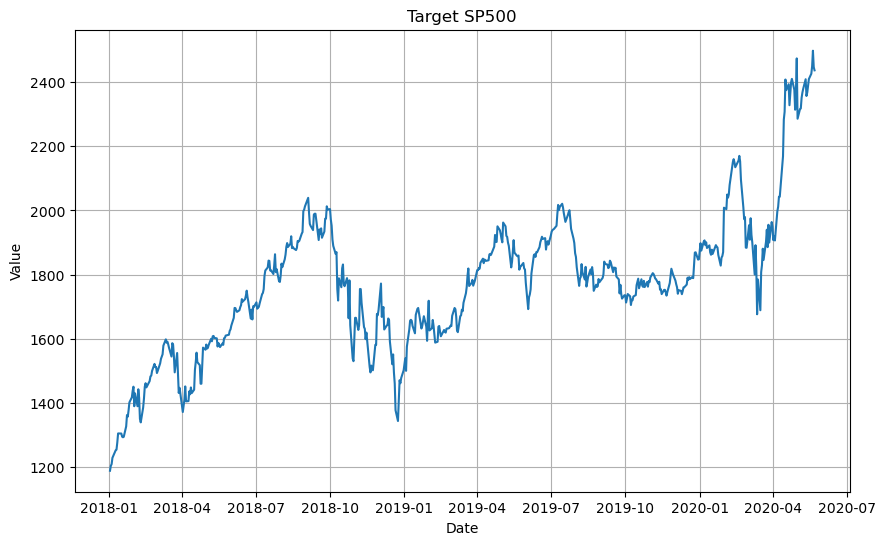

In [10]:
import matplotlib.pyplot as plt

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(target_amzn.index, target_amzn.values)
plt.title('Target SP500')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [11]:
## Target :  Adj Close Price 
target_msft = msft_data['Adj Close']
target_msft.name = "SP500"
target_msft.head()

2018-01-02    82.798996
2018-01-03    83.184326
2018-01-04    83.916473
2018-01-05    84.956886
2018-01-08    85.043571
Name: SP500, dtype: float64

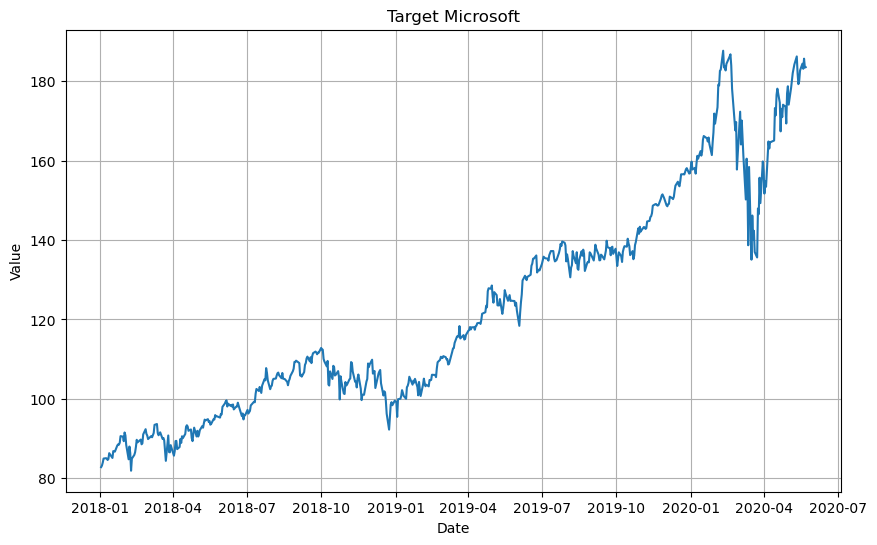

In [12]:
import matplotlib.pyplot as plt

#plot the data
plt.figure(figsize=(10, 6))
plt.plot(target_msft.index, target_msft.values)
plt.title('Target Microsoft')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.show()

## Indicators

### Sentiment Indicators

The following sentiment indicators are calculated:
- **BULL**: Sum of positive part score, certainty part score, and financial upward part score.
- **BEAR**: Sum of negative part score, uncertainty part score, and financial downward part score.
- **BBr**: 100 * BULL / (BULL + BEAR)
- **PNlog**: 0.5 * log((positive part score + 1) / (negative part score + 1))

### Momentum Indicator

The momentum indicator used is:
- **ROC (Rate of Change)**: Percentage change of the adjusted close price over a specified window.

### Parameters
- `bbr_threshold`: Threshold for BBr indicator.
- `pnlog_threshold`: Threshold for PNlog indicator.
- `long_only`: Boolean flag to indicate if the strategy is long-only or allows short selling.
- `w_size`: Window size for rolling analysis (254 for 1 year, 127 for 6 months).


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
def load_and_prepare_data(file_path):
    data = pd.read_csv(file_path)
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    return data

msft_data = load_and_prepare_data('dataSent/MSFT.csv')
amzn_data = load_and_prepare_data('dataSent/AMZN.csv')

# Calculate sentiment indicators
def calculate_sentiment_indicators(data):
    data['BULL'] = data['positivePartscr'] + data['certaintyPartscr'] + data['finupPartscr']
    data['BEAR'] = data['negativePartscr'] + data['uncertaintyPartscr'] + data['findownPartscr']
    data['BULL_BEAR'] = data['BULL'] + data['BEAR']
    
    # Replace 0 with NaN to avoid division by 0
    data['BULL_BEAR'].replace(0, np.nan, inplace=True)
    
    # Calculate BBr and fill NAs
    data['BBr'] = 100 * data['BULL'] / data['BULL_BEAR']
    data['BBr'].fillna(method='ffill', inplace=True)
    data['BBr'].fillna(method='bfill', inplace=True)
    
    # Calculate PNlog
    data['PNlog'] = 0.5 * np.log((data['positivePartscr'] + 1) / (data['negativePartscr'] + 1))
    
    return data

msft_data = calculate_sentiment_indicators(msft_data)
amzn_data = calculate_sentiment_indicators(amzn_data)

# Calculate Rate of Change (ROC)
def calculate_momentum(data, window=12):
    data['ROC'] = data['Adj Close'].pct_change(periods=window)
    return data

msft_data = calculate_momentum(msft_data)
amzn_data = calculate_momentum(amzn_data)

# Define the sentiment-driven momentum strategy
def sentiment_momentum_strategy(df, bbr_threshold=60, pnlog_threshold=0, long_only=True):
    signals = pd.DataFrame(index=df.index)
    signals['signal'] = 0.0

    # Generate buy signals
    buy_conditions = (
        (df['ROC'] > 0) &
        (df['BBr'] > bbr_threshold) &
        (df['PNlog'] > pnlog_threshold)
    )
    signals.loc[buy_conditions, 'signal'] = 1.0

    # Generate sell signals
    if not long_only:
        sell_conditions = (
            (df['ROC'] < 0) &
            (df['BBr'] < (100 - bbr_threshold)) &
            (df['PNlog'] < -pnlog_threshold)
        )
        signals.loc[sell_conditions, 'signal'] = -1.0

    # Calculate returns
    signals['returns'] = df['Adj Close'].pct_change()
    signals['strategy_returns'] = signals['returns'] * signals['signal'].shift(1)

    return signals


## Strategy Definition

### Buy Signal
A buy signal is generated when:
- ROC > 0
- BBr > bbr_threshold (default is 60)
- PNlog > pnlog_threshold (default is 0)

### Sell Signal
A sell signal is generated when:
- ROC < 0
- BBr < (100 - bbr_threshold)
- PNlog < -pnlog_threshold

In [14]:
def rolling_test_sentiment_strategy(data, bbr_threshold=60, pnlog_threshold=0, longshort=0, w_size=252):
    """
    Calculates the performance of a sentiment-driven momentum strategy using rolling window analysis.

    Parameters:
    data (DataFrame): DataFrame containing the stock data and sentiment indicators.
    bbr_threshold (int, optional): Threshold for BBr. Default is 60.
    pnlog_threshold (float, optional): Threshold for PNlog. Default is 0.
    longshort (int, optional): Long/short strategy flag. Default is 0 (long-only).
    w_size (int, optional): Window size. Default is 252 (1 year).

    Returns:
    DataFrame: DataFrame containing the performance statistics of the strategy and the benchmark.
    """
    signals = sentiment_momentum_strategy(data, bbr_threshold, pnlog_threshold, long_only=not longshort)

    bmk_returns = data['Adj Close'].pct_change().rename("BH")
    strategy_returns = signals['strategy_returns'].rename("Me")
    tt = pd.concat([bmk_returns, strategy_returns], axis=1).dropna()
    n_windows = int(tt.shape[0] - w_size)
    if n_windows < 1:
        raise ValueError("Window size too large")
    
    perform = []
    for i in range(n_windows):
        bh_stra = tt.iloc[i:w_size+i, 0]
        my_stra = tt.iloc[i:w_size+i, 1]
        perform.append([bh_stra.mean(), my_stra.mean()])
    perform = np.array(perform)
    
    bh_means = perform[:,0].mean()
    me_means = perform[:,1].mean()
    mean_perf = np.array([bh_means, me_means])
    mean_perf = pd.DataFrame(mean_perf, index=["BH", "Me"], columns=["AvgPerf"])
    
    return {"AvgPerf": mean_perf, "NumWindows": n_windows}

# Example usage
rolling_test_sentiment_strategy(msft_data)


{'AvgPerf':      AvgPerf
 BH  0.001356
 Me  0.000232,
 'NumWindows': 349}

### Performing a grid search to find the best parameters.

In [15]:
from itertools import product

# Define the parameter grid
bbr_thresholds = [50, 60, 70,80]
pnlog_thresholds = [-0.05,0, 0.05,0.1, 0.2]
window_sizes = [254,127]
longshort_flags = [0,1]  # 0 for long-only, 1 for long-short

# Grid search
best_params = None
best_performance = -np.inf
results = []

for bbr_threshold, pnlog_threshold, w_size, longshort in product(bbr_thresholds, pnlog_thresholds, window_sizes, longshort_flags):
    try:
        performance_grid = rolling_test_sentiment_strategy(msft_data, bbr_threshold, pnlog_threshold, longshort, w_size)
        avg_perf = performance_grid['AvgPerf'].loc['Me', 'AvgPerf']
        results.append((bbr_threshold, pnlog_threshold, w_size, longshort, avg_perf))
        if avg_perf > best_performance:
            best_performance = avg_perf
            best_params = (bbr_threshold, pnlog_threshold, w_size, longshort)
    except ValueError as e:
        # Handle case where window size is too large
        print(f"Skipping parameters due to error: {e}")

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['BBR Threshold', 'PNlog Threshold', 'Window Size', 'LongShort', 'AvgPerf'])
print("Grid Search Results:")
print(results_df)

print("Best Parameters:")
print(best_params)


Grid Search Results:
    BBR Threshold  PNlog Threshold  Window Size  LongShort   AvgPerf
0              50            -0.05          254          0  0.000720
1              50            -0.05          254          1  0.000288
2              50            -0.05          127          0  0.000801
3              50            -0.05          127          1  0.000420
4              50             0.00          254          0  0.000267
..            ...              ...          ...        ...       ...
75             80             0.10          127          1  0.000000
76             80             0.20          254          0  0.000000
77             80             0.20          254          1  0.000000
78             80             0.20          127          0  0.000000
79             80             0.20          127          1  0.000000

[80 rows x 5 columns]
Best Parameters:
(50, -0.05, 127, 0)


## Ploting and Results

The best parameters identified through grid search are applied to the strategy, and the performance metrics are calculated. The strategy performance is visualized through multiple plots including adjusted close prices with buy/sell signals, ROC, BBr, PNlog, and cumulative strategy returns.

MSFT Best Sentiment Momentum Performance:
 Cumulative Return            0.408818
Annual Return                0.154556
Annualized Sharpe Ratio    266.538668
Win %                        0.577558
Annualized Volatility        0.146126
Maximum Drawdown            -0.526671
Max Length Drawdown          0.000000
n.trades                    85.500000
Name: strategy_returns, dtype: float64

AMZN Best Sentiment Momentum Performance:
 Cumulative Return            0.345036
Annual Return                0.132344
Annualized Sharpe Ratio    199.493584
Win %                        0.574144
Annualized Volatility        0.167176
Maximum Drawdown            -0.365533
Max Length Drawdown          0.000000
n.trades                    76.500000
Name: strategy_returns, dtype: float64


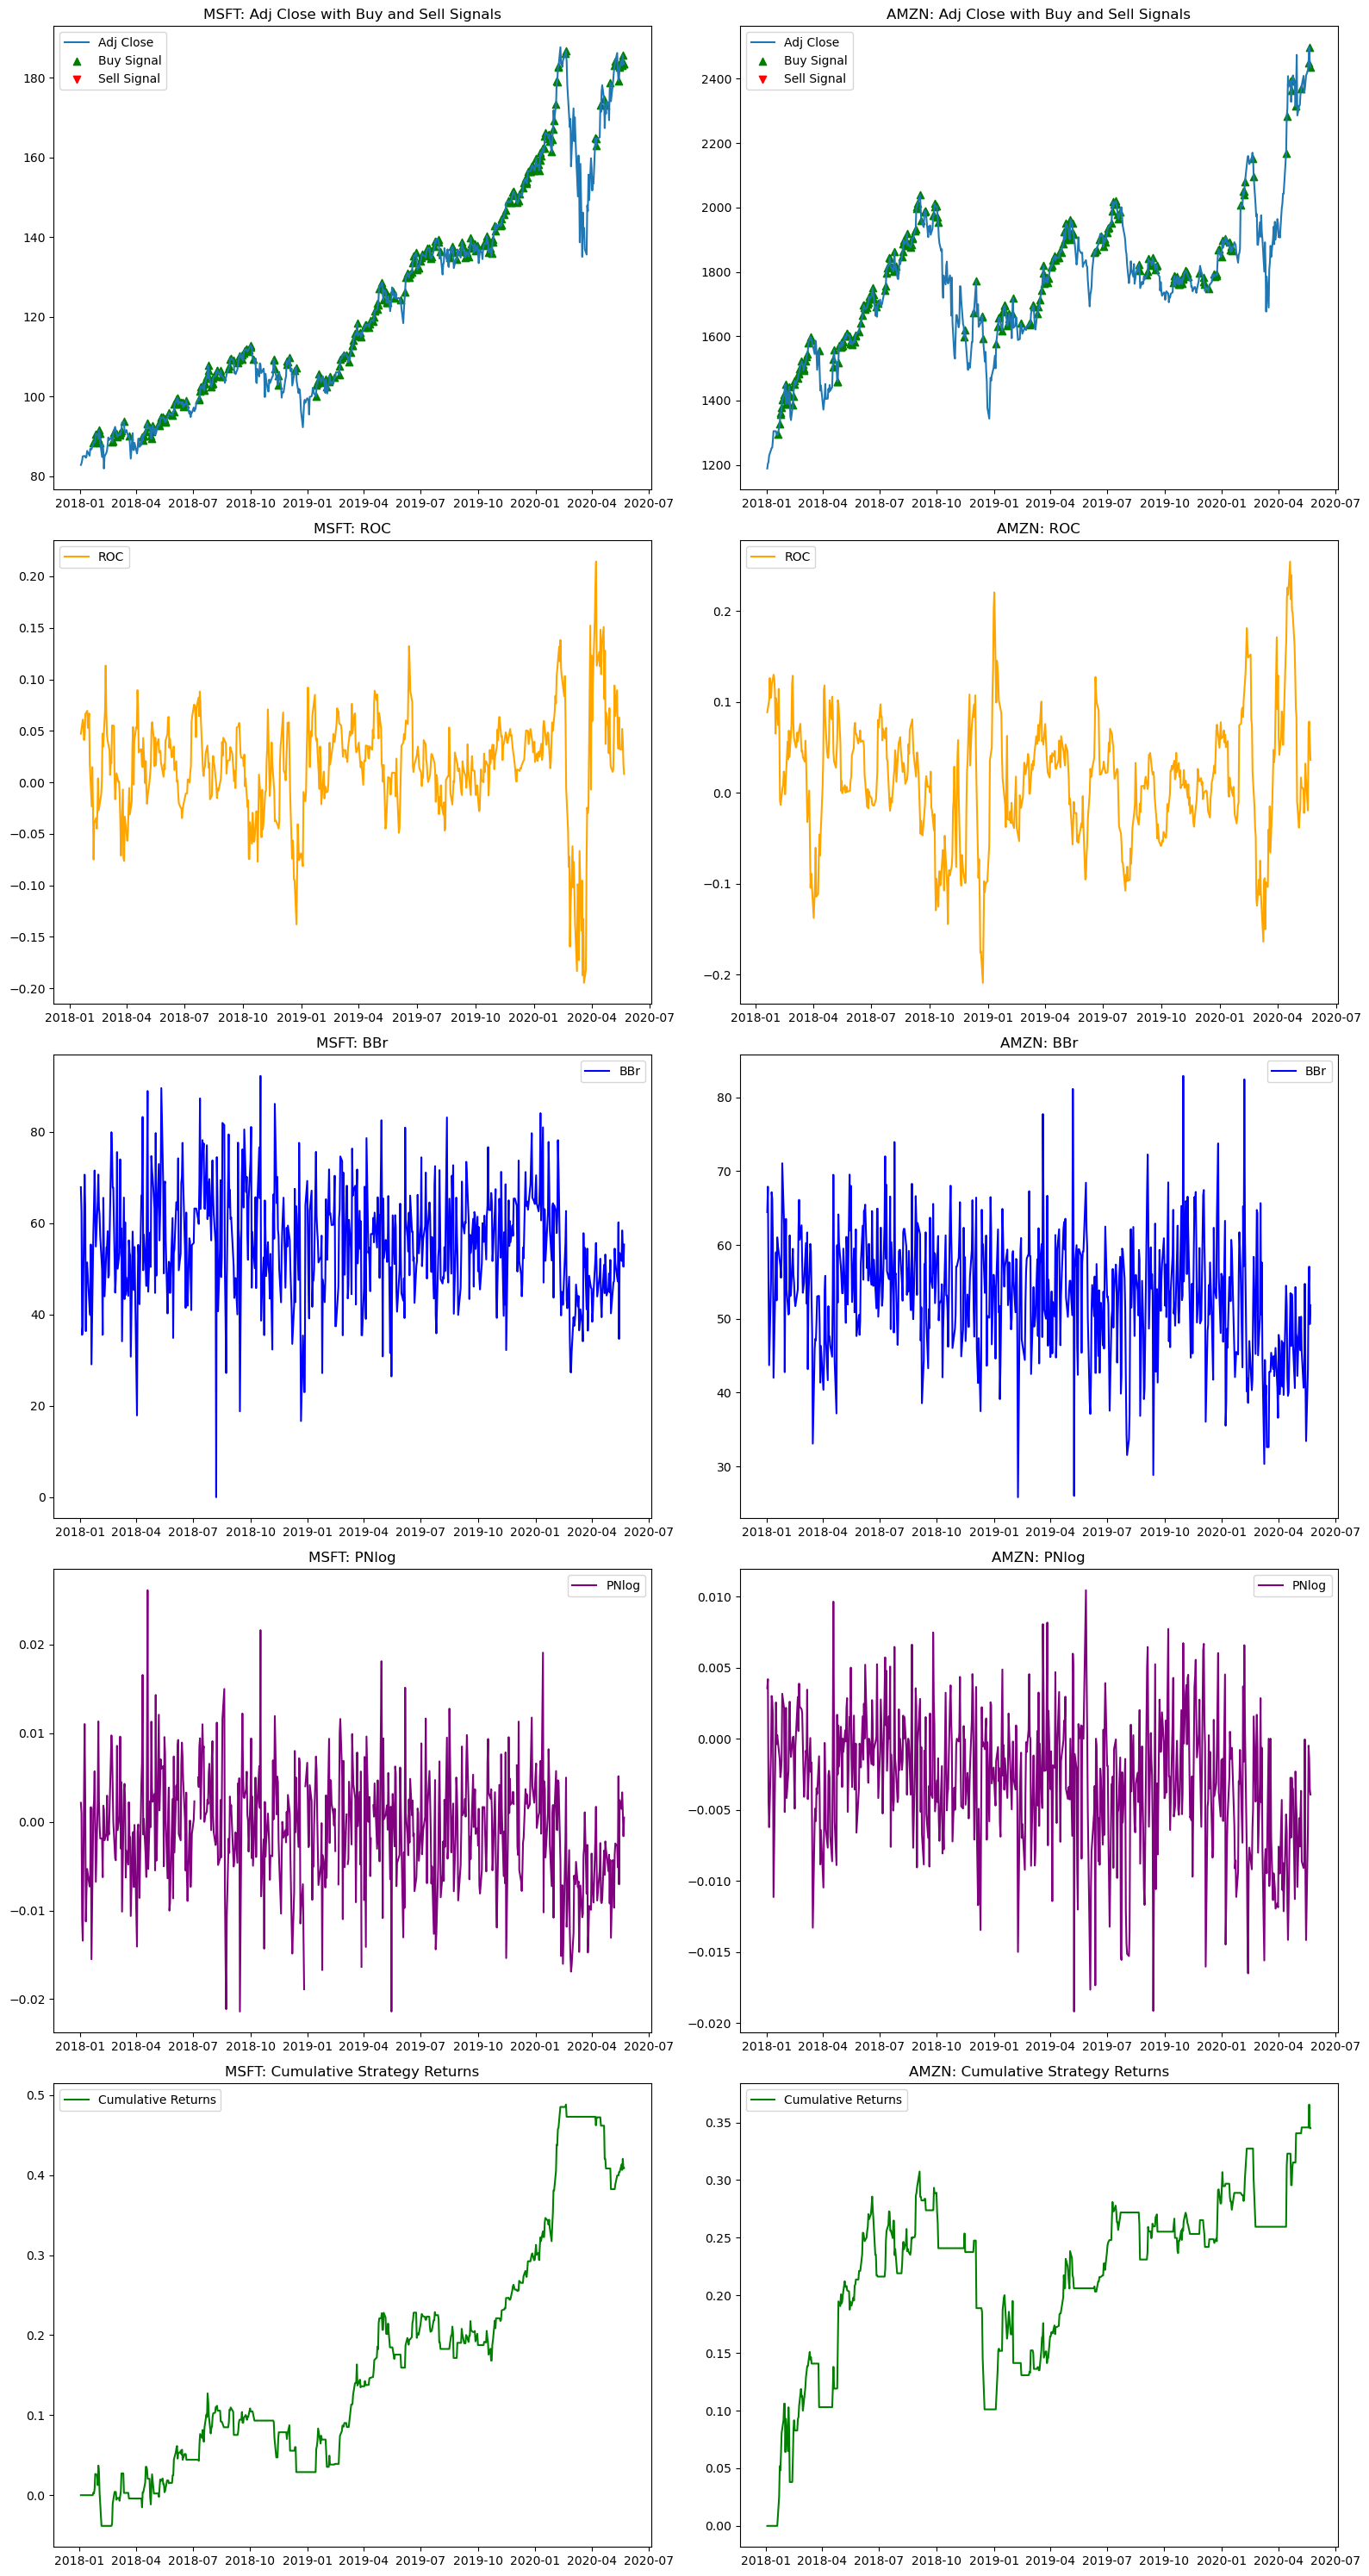

In [16]:
best_bbr_threshold, best_pnlog_threshold, best_w_size, best_longshort = best_params

# Apply the best parameters
msft_signals_best = sentiment_momentum_strategy(msft_data, best_bbr_threshold, best_pnlog_threshold, long_only=not best_longshort)
amzn_signals_best = sentiment_momentum_strategy(amzn_data, best_bbr_threshold, best_pnlog_threshold, long_only=not best_longshort)

# Calculate performance of the best strategy
msft_performance_best = performance(msft_signals_best['strategy_returns'].dropna(), ntrades=msft_signals_best['signal'].diff().abs().sum()/2)
amzn_performance_best = performance(amzn_signals_best['strategy_returns'].dropna(), ntrades=amzn_signals_best['signal'].diff().abs().sum()/2)

print("MSFT Best Sentiment Momentum Performance:\n", msft_performance_best)
print("\nAMZN Best Sentiment Momentum Performance:\n", amzn_performance_best)

# Plotting all figures together
fig, axs = plt.subplots(5, 2, figsize=(16, 30))

# MSFT Plots
axs[0, 0].plot(msft_data.index, msft_data['Adj Close'], label='Adj Close')
axs[0, 0].scatter(msft_signals_best.index, msft_signals_best['signal'].where(msft_signals_best['signal'] == 1) * msft_data['Adj Close'], marker='^', color='green', label='Buy Signal')
axs[0, 0].scatter(msft_signals_best.index, msft_signals_best['signal'].where(msft_signals_best['signal'] == -1) * (-1)*msft_data['Adj Close'], marker='v', color='red', label='Sell Signal')
axs[0, 0].set_title('MSFT: Adj Close with Buy and Sell Signals')
axs[0, 0].legend()

axs[1, 0].plot(msft_data.index, msft_data['ROC'], label='ROC', color='orange')
axs[1, 0].set_title('MSFT: ROC')
axs[1, 0].legend()

axs[2, 0].plot(msft_data.index, msft_data['BBr'], label='BBr', color='blue')
axs[2, 0].set_title('MSFT: BBr')
axs[2, 0].legend()

axs[3, 0].plot(msft_data.index, msft_data['PNlog'], label='PNlog', color='purple')
axs[3, 0].set_title('MSFT: PNlog')
axs[3, 0].legend()

axs[4, 0].plot(msft_signals_best.index, msft_signals_best['strategy_returns'].cumsum(), label='Cumulative Returns', color='green')
axs[4, 0].set_title('MSFT: Cumulative Strategy Returns')
axs[4, 0].legend()

# AMZN Plots
axs[0, 1].plot(amzn_data.index, amzn_data['Adj Close'], label='Adj Close')
axs[0, 1].scatter(amzn_signals_best.index, amzn_signals_best['signal'].where(amzn_signals_best['signal'] == 1) * amzn_data['Adj Close'], marker='^', color='green', label='Buy Signal')
axs[0, 1].scatter(amzn_signals_best.index, amzn_signals_best['signal'].where(amzn_signals_best['signal'] == -1) * (-1)*amzn_data['Adj Close'], marker='v', color='red', label='Sell Signal')
axs[0, 1].set_title('AMZN: Adj Close with Buy and Sell Signals')
axs[0, 1].legend()

axs[1, 1].plot(amzn_data.index, amzn_data['ROC'], label='ROC', color='orange')
axs[1, 1].set_title('AMZN: ROC')
axs[1, 1].legend()

axs[2, 1].plot(amzn_data.index, amzn_data['BBr'], label='BBr', color='blue')
axs[2, 1].set_title('AMZN: BBr')
axs[2, 1].legend()

axs[3, 1].plot(amzn_data.index, amzn_data['PNlog'], label='PNlog', color='purple')
axs[3, 1].set_title('AMZN: PNlog')
axs[3, 1].legend()

axs[4, 1].plot(amzn_signals_best.index, amzn_signals_best['strategy_returns'].cumsum(), label='Cumulative Returns', color='green')
axs[4, 1].set_title('AMZN: Cumulative Strategy Returns')
axs[4, 1].legend()

plt.tight_layout()
plt.show()
